In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
np.random.seed(1234)
random.seed(1234)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/titanic_com/data/train.csv')
test_df=pd.read_csv('/content/drive/MyDrive/titanic_com/data/test.csv')
submission=pd.read_csv('/content/drive/MyDrive/titanic_com/data/gender_submission.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df[['Embarked','Survived','PassengerId']].dropna()

,Embarked,Survived,PassengerId
0,S,0,1
1,C,1,2
2,S,1,3
3,S,1,4
4,S,0,5
...,...,...,...
886,S,0,887
887,S,1,888
888,S,0,889
889,C,1,890


In [ ]:
embarked_df=train_df[['Embarked','Survived','PassengerId']].groupby(['Embarked','Survived']).count().unstack()

In [ ]:
embarked_df['Survived_rate']=embarked_df.iloc[:,0]/(embarked_df.iloc[:,0]+embarked_df.iloc[:,1])

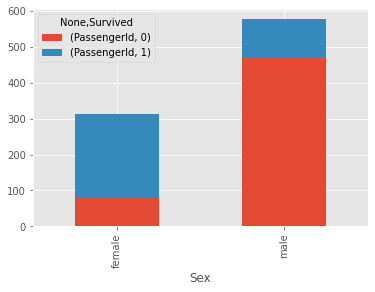

In [ ]:
sex_df=train_df[['Sex','Survived','PassengerId']].dropna().groupby(['Sex','Survived']).count().unstack()
sex_df.plot.bar(stacked=True)

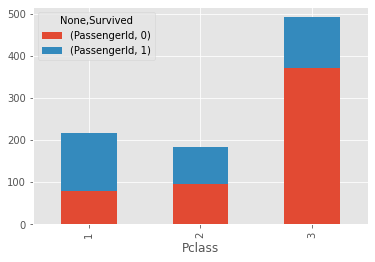

In [ ]:
ticket_df=train_df[['Pclass','Survived','PassengerId']].dropna().groupby(['Pclass','Survived']).count().unstack()
ticket_df.plot.bar(stacked=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


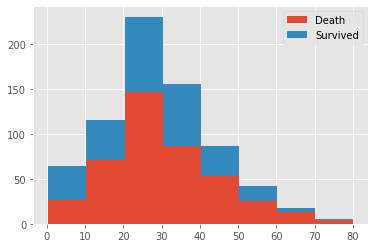

In [ ]:
plt.hist((train_df[train_df['Survived']==0]['Age'].values,train_df[train_df['Survived']==1]['Age'].values),histtype='barstacked',bins=8,label=('Death','Survived'))
plt.legend()

In [ ]:
train_df_corr=pd.get_dummies(train_df,columns=['Sex'],drop_first=True)

In [ ]:
train_df_corr=pd.get_dummies(train_df_corr,columns=['Embarked'])

In [ ]:
train_df_corr

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,NaN,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,NaN,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,1,1,0,0


In [ ]:
train_corr=train_df_corr.corr()

In [ ]:
train_corr

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,0.042939,-0.001205,-0.033606,0.022148
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351,0.168240,0.003650,-0.155660
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900,-0.243292,0.221009,0.081720
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254,0.036261,-0.022405,-0.032523
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631,-0.059528,-0.026354,0.070941
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489,-0.011069,-0.081228,0.063036
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333,0.269335,-0.117216,-0.166603
Sex_male,0.042939,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000,-0.082853,-0.074115,0.125722
Embarked_C,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,-0.082853,1.000000,-0.148258,-0.778359
Embarked_Q,-0.033606,0.003650,0.221009,-0.022405,-0.026354,-0.081228,-0.117216,-0.074115,-0.148258,1.000000,-0.496624


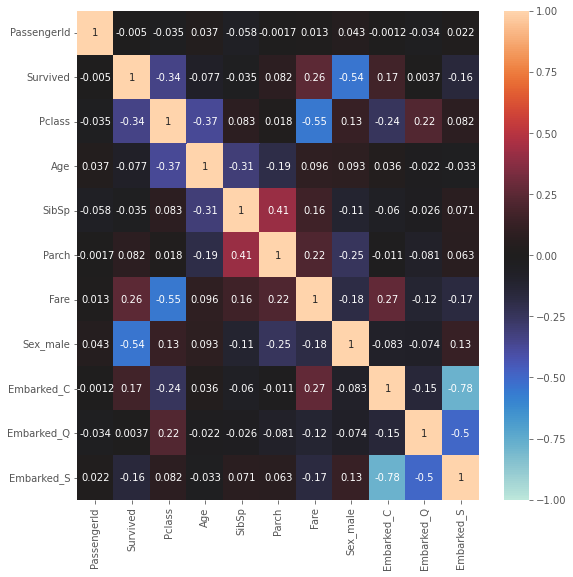

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(train_corr,vmax=1,vmin=-1,center=0,annot=True)

In [ ]:
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)

In [ ]:
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [ ]:
Fare_mean=all_df[['Pclass','Fare']].groupby('Pclass').mean().reset_index()
Fare_mean.columns=['Pclass','Fare_mean']

In [ ]:
Fare_mean

,Pclass,Fare_mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [ ]:
all_df=pd.merge(all_df,Fare_mean,on='Pclass',how='left')
all_df.loc[(all_df['Fare'].isnull()),'Fare']=all_df['Fare_mean']
all_df=all_df.drop('Fare_mean',axis=1)

In [ ]:
name_df=all_df['Name'].str.split('[,.]',2,expand=True)

In [ ]:
name_df.columns=['family_name','honorific','name']
name_df

,family_name,honorific,name
0,Braund,Mr,Owen Harris
1,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss,Laina
3,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,Allen,Mr,William Henry
...,...,...,...
1304,Spector,Mr,Woolf
1305,Oliva y Ocana,Dona,Fermina
1306,Saether,Mr,Simon Sivertsen
1307,Ware,Mr,Frederick


In [ ]:
name_df['family_name']=name_df['family_name'].str.strip()
name_df['honorific']=name_df['honorific'].str.strip()
name_df['name']=name_df['name'].str.strip()

In [ ]:
name_df['honorific'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Mme               1
Jonkheer          1
the Countess      1
Dona              1
Sir               1
Lady              1
Capt              1
Don               1
Name: honorific, dtype: int64

In [ ]:
all_df=pd.concat([all_df,name_df],axis=1)

In [ ]:
train_df=pd.concat([train_df,name_df[0:len(train_df)].reset_index(drop=True)],axis=1)
test_df=pd.concat([test_df,name_df[len(train_df):].reset_index(drop=True)],axis=1)

In [ ]:
honorific_age_mean=all_df[['honorific','Age']].groupby(['honorific']).mean().reset_index()
honorific_age_mean.columns=['honorific','honorific_Age']

In [ ]:
all_df=pd.merge(all_df,honorific_age_mean,on='honorific',how='left')
all_df.loc[(all_df['Age'].isnull()),'Age']=all_df['honorific_Age']
all_df=all_df.drop(['honorific_Age'],axis=1)

In [ ]:
all_df['family_num']=all_df['Parch']+all_df['SibSp']

In [ ]:
all_df.loc[all_df['family_num']==0,'alone']=1
all_df['alone'].fillna(0,inplace=True)

In [ ]:
all_df=all_df.drop(['PassengerId','name','family_name','Ticket','Cabin'],axis=1)

In [ ]:
all_df=all_df.drop('Name',axis=1)

In [ ]:
all_df.loc[~((all_df['honorific']=='Mr')|(all_df['honorific']=='Miss')|(all_df['honorific']=='Mrs')|(all_df['honorific']=='Master')),'honorific']='other'

In [ ]:
all_df.honorific.value_counts()

Mr        757
Miss      260
Mrs       197
Master     61
other      34
Name: honorific, dtype: int64

In [ ]:
all_df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,male,22.0,1,0,7.2500,S,Mr,1,0.0
1,1.0,1,female,38.0,1,0,71.2833,C,Mrs,1,0.0
2,1.0,3,female,26.0,0,0,7.9250,S,Miss,0,1.0


In [ ]:
all_df['Embarked'].fillna('missing',inplace=True)

In [ ]:
le=LabelEncoder()
le=le.fit(all_df['Sex'])
all_df['Sex']=le.transform(all_df['Sex'])

In [ ]:
le=LabelEncoder()
le=le.fit(all_df['Sex'])
all_df['Sex']=le.transform(all_df['Sex'])
le=le.fit(all_df['Embarked'])
all_df['Embarked']=le.transform(all_df['Embarked'])
le=le.fit(all_df['honorific'])
all_df['honorific']=le.transform(all_df['honorific'])

In [ ]:
all_df.head()2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
0,0.0,3,1,22.0,1,0,7.2500,2,2,1,0.0
1,1.0,1,0,38.0,1,0,71.2833,0,3,1,0.0
2,1.0,3,0,26.0,0,0,7.9250,2,1,0,1.0
3,1.0,1,0,35.0,1,0,53.1000,2,3,1,0.0
4,0.0,3,1,35.0,0,0,8.0500,2,2,0,1.0


In [ ]:
train_X=all_df[~all_df['Survived'].isnull()].drop('Survived',axis=1).reset_index(drop=True)
train_Y=train_df['Survived']
test_X=all_df[all_df['Survived'].isnull()].drop('Survived',axis=1).reset_index(drop=True)

In [ ]:
X_train,X_vaild,y_train,y_vaild=train_test_split(train_X,train_Y,test_size=0.2)

In [ ]:
categories=['Embarked','Pclass','Sex','honorific','alone']

In [ ]:
lgb_train=lgb.Dataset(X_train,y_train,categorical_feature=categories)
lgb_eval=lgb.Dataset(X_vaild,y_vaild,categorical_feature=categories,reference=lgb_train)

In [ ]:
lgb_params={
    "objective":"binary",
    "random_seed":1234
}

In [ ]:
model_lgb=lgb.train(lgb_params,lgb_train,valid_sets=lgb_eval,num_boost_round=100,early_stopping_rounds=20,verbose_eval=10)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.465597
[20]	valid_0's binary_logloss: 0.42253
[30]	valid_0's binary_logloss: 0.424173
[40]	valid_0's binary_logloss: 0.438413
Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.417458


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [ ]:
importance=pd.DataFrame(model_lgb.feature_importance(),index=X_train.columns,columns=['importance']).sort_values(by='importance',ascending=True)

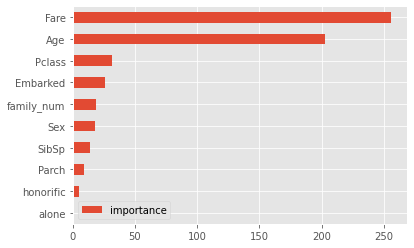

In [72]:
importance.plot.barh()

In [77]:
y_pred=model_lgb.predict(X_vaild,num_iteration=model_lgb.best_iteration)

In [78]:
accuracy_score(y_vaild,np.round(y_pred))

0.8435754189944135

In [79]:
lgb_model={
    'objective':'binary',
    'max_bin':331,
    'num_leaves':20,
    'min_data_in_leaf':57,
    'andom':1234
}

In [80]:
lgb_train=lgb.Dataset(X_train,y_train,categorical_feature=categories)
lgb_eval=lgb.Dataset(X_vaild,y_vaild,categorical_feature=categories,reference=lgb_train)

In [82]:
model_lgb=lgb.train(lgb_model,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=100,
                    early_stopping_rounds=20,
                    verbose_eval=10)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.470659
[20]	valid_0's binary_logloss: 0.425654
[30]	valid_0's binary_logloss: 0.413748
[40]	valid_0's binary_logloss: 0.410545
[50]	valid_0's binary_logloss: 0.412232
[60]	valid_0's binary_logloss: 0.407988
[70]	valid_0's binary_logloss: 0.407494
[80]	valid_0's binary_logloss: 0.410995
[90]	valid_0's binary_logloss: 0.413203
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.406565


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [83]:
y_pred=model_lgb.predict(X_vaild,num_iteration=model_lgb.best_iteration)

In [84]:
accuracy_score(y_vaild,np.round(y_pred))

0.8491620111731844

In [85]:
folds=3
kf=KFold(n_splits=folds)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.503031
[20]	valid_0's binary_logloss: 0.465863
[30]	valid_0's binary_logloss: 0.454056
[40]	valid_0's binary_logloss: 0.451228
[50]	valid_0's binary_logloss: 0.44724
[60]	valid_0's binary_logloss: 0.447342
[70]	valid_0's binary_logloss: 0.450126
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.445648
0.8249158249158249
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_logloss: 0.482264
[20]	valid_0's binary_logloss: 0.440853
[30]	valid_0's binary_logloss: 0.435016
[40]	valid_0's binary_logloss: 0.433286
[50]	valid_0's binary_logloss: 0.432128
[60]	valid_0's binary_logloss: 0.430387
[70]	valid_0's binary_logloss: 0.431241
[80]	valid_0's binary_logloss: 0.438053
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.429561
0.8181818181818182
Training until validation scores don't improve for 20 rounds.
[10]	valid_0's binary_loglo

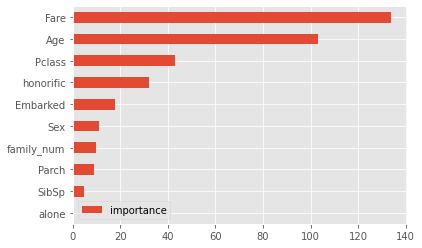

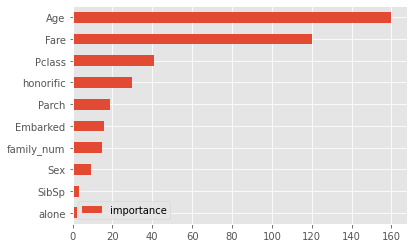

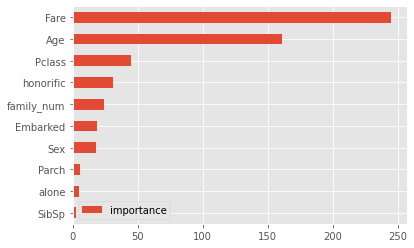

In [93]:
models=[]
for train_index,val_index in kf.split(train_X):
  X_train=train_X.iloc[train_index]
  X_vaild=train_X.iloc[val_index]
  y_train=train_Y.iloc[train_index]
  y_vaild=train_Y.iloc[val_index]

  lgb_train=lgb.Dataset(X_train,y_train,categorical_feature=categories)
  lgb_eval=lgb.Dataset(X_vaild,y_vaild,categorical_feature=categories,reference=lgb_train)
  model_lgb=lgb.train(
      lgb_model,
      lgb_train,
      valid_sets=lgb_eval,
      num_boost_round=100,
      early_stopping_rounds=20,
      verbose_eval=10
  )
  y_pred=model_lgb.predict(X_vaild,num_iteration=model_lgb.best_iteration)
  importance=pd.DataFrame(model_lgb.feature_importance(),index=X_train.columns,columns=['importance']).sort_values(by='importance',ascending=True)
  importance.plot.barh()
  print(accuracy_score(y_vaild,np.round(y_pred)))
  models.append(model_lgb)

In [94]:
preds=[]
for model in models:
  pred=model.predict(test_X)
  preds.append(pred)

In [104]:
preds_array=np.array(preds)
preds_mean=np.mean(preds_array,axis=0)

In [105]:
preds_int=(preds_mean>0.5).astype(int)

In [107]:
submission['Survived']=preds_int

In [108]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
